In [148]:
import numpy as np
import pylidc as pl
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import os
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, CategoricalColorMapper
from bokeh.palettes import brewer
from fuzzywuzzy import process

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from maps import slider_map, match_names, replace_names

# Analysing medical data to help improve society's quality of life

How can we use medical data to help improve society's quality of life?<br>
There is endless types of medical data out there for different diseases, which data should we use in order to help as many people as possible?<br>

To explore this question, we have subdivided it into some more specific areas that can gain us different types of information. They are shown in this scheme.

![title](Images/scheme.png)

# 1. Which diseases have the most significant negative impact on society's quality of life as of today? How does differ between countries and over time?
The ***prevelance*** of the disease alone is not enough to quantify this, take herpes for example. The herpes simplex virus is one of the most common diseases on earth. It is estimated that well over 50% of the world population is infected with the virus. However, most people are completely unaware that they are and show little to no symptoms while others do have severe symptoms. There is no cure and once you are infected, the virus will most likely stay in your body for the rest of your life.<br> 
***Conclusion:*** quality of life is only significantly effected if the disease causes pain or limits the patient ablilities.

The most severe effect of a disease is when it causes death, after all, you can't have any "quality of life" anymore if your life has come to an end. <br> 
***Conclusion:*** If we want to have a big impact on society's quality of life it might be interesting to look at the diseases that cause the most deaths.

## 1.1 Most common causes of death

We start by loading data from the GBD dataset, which contains the number of deaths from different causes, for different countries, from the year 1990 to 2017.

In [73]:
data=pd.read_csv("data/annual-number-of-deaths-by-cause.csv" )
print(data.shape)
data.head(5)

(6686, 36)


Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0  Afghanistan  AFG  1990     856.0                  28372.0          2708.0   
1  Afghanistan  AFG  1991     908.0                  30368.0          2851.0   
2  Afghanistan  AFG  1992     970.0                  33035.0          3057.0   
3  Afghanistan  AFG  1993    1066.0                  36512.0          3329.0   
4  Afghanistan  AFG  1994    1161.0                  40285.0          3641.0   

   Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0               3394.0         1349.0                                 6177.0   
1               3641.0         1443.0                                 6522.0   
2               3967.0         1572.0                                 7009.0   
3               4398.0         1735.0                                 7655.0   
4               4870.0         1911.0                                 8377.0   

   Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0             1708.0  ...                                       222.0   
1             1792.0  ...                                       230.0   
2             1911.0  ...                                       250.0   
3             2071.0  ...                                       289.0   
4             2243.0  ...                                       315.0   

   Nutritional deficiencies  Suicide  Execution  Meningitis (deaths)  \
0                     567.0    703.0        NaN          6469.977091   
1                     588.0    754.0        NaN          6347.158764   
2                     623.0    820.0        NaN          6659.741428   
3                     674.0    894.0        NaN          8068.386263   
4                     731.0    977.0        NaN          9432.845127   

   Lower respiratory infections (deaths)  \
0                           22836.912346   
1                           22325.633931   
2                           23205.280750   
3                           28229.715397   
4                           32652.297630   

   Intestinal infectious diseases (deaths)  \
0                               295.382207   
1                               303.866598   
2                               317.750121   
3                               333.978331   
4                               348.419085   

   Protein-energy malnutrition (deaths)  Conflict (deaths)  Terrorism (deaths)  
0                           1607.703797             1508.0                12.0  
1                           1558.132316             3498.0                68.0  
2                           1617.721576             4341.0                49.0  
3                           1931.808553                NaN                 NaN  
4                           2351.629206             9090.0                22.0  

[5 rows x 36 columns]

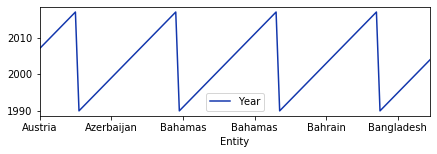

In [74]:
# For each "Entity" the year ranges from 1990 to 2017
data[380:490].plot(x='Entity',y='Year',color='#1337AD', figsize = (7,2))

In [75]:
# One of the entities is "world" which contains the summations over all countries. 
# Let's see which diseases are most prevalent world wide
df = data[data["Entity"]=='World'].iloc[:,2:].sort_values(6572, ascending=False, axis=1)

Text(0.5, 1.0, 'Amount of recorded deaths 1990-2017')

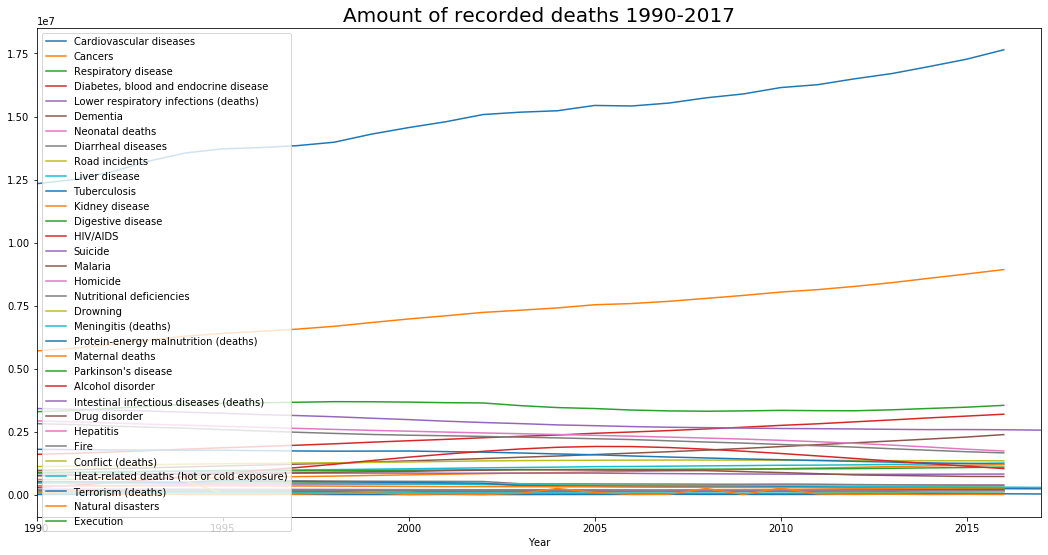

In [76]:
df.plot(x='Year', figsize=(18,9))
plt.title('Amount of recorded deaths 1990-2017', fontsize=20)

It is clear that cardiovascular disease is by far the most common cause of death, followed by cancer, respiratory disease, ... <br> Note that cardiovascular diease is also the faster growing cause of death!

### 1.1.1 Difference between countries

Lets normalize this dataframe to obtain a ratio and not a strict number of deaths, to be able to compare between different countries.

In [77]:
# Copy the df 
normalized = data.copy()

In [78]:
# Check the type of the values, to see if any problems. 
normalized.dtypes

Entity                                         object
Code                                           object
Year                                            int64
Dementia                                      float64
Cardiovascular diseases                       float64
Kidney disease                                float64
Respiratory disease                           float64
Liver disease                                 float64
Diabetes, blood and endocrine disease         float64
Digestive disease                             float64
Hepatitis                                     float64
Cancers                                       float64
Parkinson's disease                           float64
Fire                                          float64
Malaria                                       float64
Drowning                                      float64
Homicide                                      float64
HIV/AIDS                                      float64
Drug disorder               

We see that Execution are not floats but object. Lets remove this column before computing the total

In [79]:
# remove the execution.
normalized = normalized.drop('Execution', 1)

# Take the colums to take into account 
column = normalized.columns.to_list()[3:]

# Compute the total 
normalized['Total'] = normalized[column].sum(axis = 1)


In [80]:
normalized.loc[ :, "Dementia" : "Terrorism (deaths)"] = normalized.loc[ :, "Dementia" : "Terrorism (deaths)"].fillna(0).div(normalized['Total'], axis = 0)

In [81]:
normalized

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
6681     Zimbabwe  ZWE  2013  0.009296                 0.099218   
6682     Zimbabwe  ZWE  2014  0.010014                 0.105632   
6683     Zimbabwe  ZWE  2015  0.010744                 0.110023   
6684     Zimbabwe  ZWE  2016  0.011585                 0.114236   
6685     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
6681        0.011727             0.021369       0.006827   
6682        0.012613             0.022560       0.007204   
6683        0.013356             0.023452       0.007553   
6684        0.014016             0.024233       0.007862   
6685        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
6681                               0.044394           0.021123  ...   
6682                               0.048202           0.022462  ...   
6683                               0.051376           0.023479  ...   
6684                               0.054342           0.024466  ...   
6685                               0.000000           0.000000  ...   

      Heat-related deaths (hot or cold exposure)  Nutritional deficiencies  \
0                                       0.001740                  0.004443   
1                                       0.001691                  0.004324   
2                                       0.001724                  0.004297   
3                                       0.001830                  0.004269   
4                                       0.001718                  0.003986   
...                                          ...                       ...   
6681                                    0.000743                  0.019341   
6682                                    0.000759                  0.020977   
6683                                    0.000882                  0.021936   
6684                                    0.000907                  0.023261   
6685                                    0.000000                  0.000000   

       Suicide  Meningitis (deaths)  Lower respiratory infections (deaths)  \
0     0.005509             0.050698                               0.178949   
1     0.005545             0.046676                               0.164180   
2     0.005656             0.045938                               0.160067   
3     0.005662             0.051103                               0.178798   
4     0.005328             0.051439                               0.178059   
...        ...                  ...                                    ...   
6681  0.012804             0.011463                               0.082555   
6682  0.013708             0.011676                               0.084

In [82]:
# Lets intereact with our data to explore it 
# Set year to 0 to show all years
@interact
def interact_normalized(year = list(np.append(normalized.Year.unique(),[0])),
                        country = list(np.append(normalized.Entity.unique(),["All"]))):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                        norm = norm[norm['Year']==year] 
            
    return norm

interactive(children=(Dropdown(description='year', options=(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 19…

We will use Plotly to plot interactive plots as our data vary in term of country and years, it will be easyer like this. 


In [83]:
# Set year to 0 to plot over all years
@interact
def scatter_plot(x=list(normalized.select_dtypes('number').columns), 
                 y=list(normalized.select_dtypes('number').columns)[1:],
                 year = list(np.append(normalized.Year.unique(),[0])),
                 country = list(np.append(normalized.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

### 1.1.2 Evolution over time

Let's look at how the prevalence and number of deaths of different diseases have changed over the years in different countries.

In [84]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2017) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
27  Afghanistan  AFG  2017  0.000000                 0.000000        0.000000   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
55      Albania  ALB  2017  0.000000                 0.000000        0.000000   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
27             0.000000       0.000000                               0.000000   
28             0.049401       0.014597                               0.034485   
55             0.000000       0.000000                               0.000000   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
27           0.000000  ...                                    0.000000   
28           0.015617  ...                                    0.000319   
55           0.000000  ...                                    0.000000   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
27                  0.000000  0.000000             0.185693   
28                  0.002486  0.008095             0.006542   
55                  0.000000  0.000000             0.046112   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
27                               0.604008   
28                               0.124942   
55                               0.945815   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
27                                 0.000000   
28                                 0.000013   
55                                 0.000000   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
27                              0.038604           0.000000   
28                              0.002097           0.000000   
55                              0.008073           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
27            0.171695   35481.574656  
28            0.000000   15687.796748  
55            0.000000     403.517623  
56            0.000028  106391.285455  

[5 rows x 36 columns]

We see that for 2017, only the columns with (deaths) in their name have values. To be able to compare better, we use the data from 2016.

In [85]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2016) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
26  Afghanistan  AFG  2016  0.010281                 0.284500        0.028502   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
54      Albania  ALB  2016  0.043395                 0.588953        0.017666   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
26             0.035139       0.014471                               0.075834   
28             0.049401       0.014597                               0.034485   
54             0.034743       0.013952                               0.031119   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
26           0.014446  ...                                    0.001583   
28           0.015617  ...                                    0.000319   
54           0.008471  ...                                    0.000226   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
26                  0.002252  0.007961             0.023632   
28                  0.002486  0.008095             0.006542   
54                  0.000226  0.008199             0.000851   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
26                               0.075644   
28                               0.124942   
54                               0.016860   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
26                                 0.001544   
28                                 0.000013   
54                                 0.000008   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
26                              0.004831           0.058442   
28                              0.002097           0.000000   
54                              0.000149           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
26            0.021752  282365.961232  
28            0.000000   15687.796748  
54            0.000000   22076.459184  
56            0.000028  106391.285455  

[5 rows x 36 columns]

Now we can compute the difference between 2016 and 1990.

In [86]:
diseases = normalized.columns.tolist()[3:35]

# Create a new dataframe, start with the country names and codes to be able to plot this on a map later
diseases_change = normalized[['Entity', 'Code']].drop_duplicates().set_index('Entity')

for disease in diseases:
    # Compute the difference between the mortality rates of 2016 and 1990 for every disease in every country
    diseases_change[disease] = normalized.groupby('Entity')[disease].apply(lambda x : x.tail(2).values[0] - x.head(1).values[0])
    
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
Yemen                      YEM  0.006957                 0.067893   
Yugoslavia            OWID_YGS       NaN                      NaN   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
Yemen                       0.006958             0.003648       0.003503   
Yugoslavia                       NaN                  NaN            NaN   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
Yemen                                              0.017656   
Yugoslavia                                              NaN   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Yugoslavia                          NaN        NaN       NaN  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
Yemen                          -0.122561   
Yugoslavia               

Let us zoom in on cardiovascular diseases and visualise this. First, we saw that this difference could not be computed for every country, so let's drop those who generated a NaN.

In [87]:
diseases_change = diseases_change.dropna(subset=['Cardiovascular diseases'])
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
World                 OWID_WRL  0.022793                 0.049485   
Yemen                      YEM  0.006957                 0.067893   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
World                       0.008582            -0.008640       0.004259   
Yemen                       0.006958             0.003648       0.003503   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
World                                              0.023363   
Yemen                                              0.017656   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
World                          0.000276  -0.001155  0.037360  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
World                          -0.033195   
Yemen                    

Let's visualise this data on a map.

Inspiration for this code and source for the shapefile: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [88]:
shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'

gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [89]:
diseases_changed_map = gdf.merge(diseases_change, left_on = 'country_code', right_on = 'Code', how = 'left')

In [90]:
#Read data to json
diseases_changed_map_json = json.loads(diseases_changed_map.to_json())

#Convert to str like object
diseases_changed_map_json_data = json.dumps(diseases_changed_map_json)

In [91]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = diseases_changed_map_json_data)

#Define a sequential multi-hue color palette.
palette = brewer['PuOr'][7]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -0.2, high = 0.2)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Change between 1990 and 2016 in proportion of total deaths by cardiovascular diseases', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Cardiovascular diseases', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

In general we see that cardiovascular disease is becoming more prevelent in developing countries while its prevelence is decreasing in developed countries.
Note that Syria is a clear outlier in the Middle East, this may very well be a result of war. <br>
These are very interesting metrics to further analyse in questions 2 and 3 (risk factors). 

To be able to do this, the difference should first be computed for all diseases in all countries, and we should make sure that the values all make sense (i.e. make sure there are no missing values, or that they are handled well).

## 1.3 Years of Life Lost

The Global Burden of Diseases dataset also contains a number of other interesting measures to see the impact of diseases on people. Let's look at one of them: Years of Life Lost (YYLs). According to the description of the dataset, this is the definition of this measure:

>Years of life lost due to premature mortality. YLLs are the multiplication of deaths and a standard life expectancy at the age of death. The standard life expectancy is derived from a life table that contains the lowest observed mortality rate at each age that has been observed in any population greater than 5 million.

To get these values, we run a new query to the GBD database to get the values for this measure, and for a few others as well, and load this data.

In [92]:
## Load data for all years
data2=pd.read_csv("data/gbd-all-measures-all-years-1.csv" )
for i in range(2,6):
    extra_dataframe = pd.read_csv("data/gbd-all-measures-all-years-" + str(i) + ".csv")
    data2 = data2.append(extra_dataframe)
    print(extra_dataframe.shape)
print(data2.shape)
data2.describe()

(500000, 10)
(500000, 10)
(500000, 10)
(129400, 10)
(2129400, 10)


year           val         upper         lower
count  2.129400e+06  2.129400e+06  2.129400e+06  2.129400e+06
mean   2.003500e+03  7.994816e+05  8.803272e+05  7.268717e+05
std    8.077749e+00  1.834825e+07  2.032091e+07  1.656793e+07
min    1.990000e+03  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.996750e+03  6.101422e-02  7.301260e-02  5.123891e-02
50%    2.003500e+03  3.843395e+02  4.717815e+02  3.005369e+02
75%    2.010250e+03  1.240885e+04  1.455895e+04  1.049930e+04
max    2.017000e+03  3.050820e+09  3.445579e+09  2.738116e+09

In [93]:
data2['location'].unique()

array(['Samoa', 'Djibouti', 'Saudi Arabia', 'El Salvador', 'China',
       'Solomon Islands', 'Guatemala', 'Serbia', 'Cape Verde', 'Eritrea',
       'Guam', 'Sudan', 'Belgium', 'Denmark', 'Comoros', 'United States',
       'Syria', 'Antigua and Barbuda', 'Chad', 'Romania', 'Cyprus',
       'Greenland', 'Costa Rica', 'Papua New Guinea', 'Slovakia',
       'North Korea', 'Tonga', 'Tunisia', 'Honduras',
       'Northern Mariana Islands', "Cote d'Ivoire", 'Ethiopia', 'Vanuatu',
       'Finland', 'Turkey', 'Taiwan (Province of China)', 'Kenya',
       'The Bahamas', 'The Gambia', 'Slovenia', 'Puerto Rico', 'Mexico',
       'Cambodia', 'United Arab Emirates', 'Barbados', 'Ghana',
       'Madagascar', 'France', 'Indonesia', 'Yemen', 'Armenia',
       'Nicaragua', 'Belarus', 'Virgin Islands, U.S.', 'Guinea', 'Belize',
       'Germany', 'Qatar', 'Panama', 'Estonia', 'Azerbaijan', 'Malawi',
       'Laos', 'South Sudan', 'Venezuela', 'Guinea-Bissau', 'Greece',
       'Afghanistan', 'Cuba', 'Canad

In [94]:
data2.head(5)

measure location   sex       age  \
0  YLLs (Years of Life Lost)    Samoa  Both  All Ages   
1  YLLs (Years of Life Lost)    Samoa  Both  All Ages   
2  YLLs (Years of Life Lost)    Samoa  Both  All Ages   
3  YLLs (Years of Life Lost)    Samoa  Both  All Ages   
4  YLLs (Years of Life Lost)    Samoa  Both  All Ages   

                                     cause   metric  year        val  \
0  Neglected tropical diseases and malaria   Number  1993  14.171667   
1  Neglected tropical diseases and malaria  Percent  1993   0.000497   
2  Neglected tropical diseases and malaria     Rate  1993   8.516462   
3                         Mental disorders   Number  1992   0.209891   
4                         Mental disorders  Percent  1992   0.000007   

       upper     lower  
0  26.041295  9.123137  
1   0.000895  0.000331  
2  15.649513  5.482548  
3   0.539310  0.096168  
4   0.000019  0.000003

In [169]:
countryInfo=pd.read_csv("data/all.csv")
countryInfo

name alpha-2 alpha-3  country-code     iso_3166-2   region  \
0          Afghanistan      AF     AFG             4  ISO 3166-2:AF     Asia   
1        Åland Islands      AX     ALA           248  ISO 3166-2:AX   Europe   
2              Albania      AL     ALB             8  ISO 3166-2:AL   Europe   
3              Algeria      DZ     DZA            12  ISO 3166-2:DZ   Africa   
4       American Samoa      AS     ASM            16  ISO 3166-2:AS  Oceania   
..                 ...     ...     ...           ...            ...      ...   
244  Wallis and Futuna      WF     WLF           876  ISO 3166-2:WF  Oceania   
245     Western Sahara      EH     ESH           732  ISO 3166-2:EH   Africa   
246              Yemen      YE     YEM           887  ISO 3166-2:YE     Asia   
247             Zambia      ZM     ZMB           894  ISO 3166-2:ZM   Africa   
248           Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW   Africa   

             sub-region intermediate-region  region-code  sub-region-code  \
0         Southern Asia                 NaN        142.0             34.0   
1       Northern Europe                 NaN        150.0            154.0   
2       Southern Europe                 NaN        150.0             39.0   
3       Northern Africa                 NaN          2.0             15.0   
4             Polynesia                 NaN          9.0             61.0   
..                  ...                 ...          ...              ...   
244           Polynesia                 NaN          9.0             61.0   
245     Northern Africa                 NaN          2.0             15.0   
246        Western Asia                 NaN        142.0            145.0   
247  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
248  Sub-Saharan Africa      Eastern Africa          2.0            202.0   

     intermediate-region-code  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
..                        ...  
244                       NaN  
245                       NaN  
246                       NaN  
247                      14.0  
248                      14.0  

[249 rows x 11 columns]

In [96]:
def match_names(countryNames, countryNames2, similarity_limit=65):
    countryNames = np.unique(countryNames)
    countryNames2 = np.unique(countryNames2)
    missingPair = np.setdiff1d(countryNames, countryNames2)
    missingPairs2 = np.setdiff1d(countryNames2, countryNames)
    pairs = []
    similarities = []
    for name in missingPair:
        name_clean = name.replace("Republic", "") #replace republic to prevent errors
        pair, similairity = process.extractOne(name_clean, missingPairs2)
        pairs.append(pair)
        similarities.append(similairity)
    for i in range(len(pairs)):
        pairDf = pd.DataFrame({'Country': missingPair, 'Replacement': pairs, 'Similarity': similarities})
        noFound = pairDf[pairDf['Similarity'] <= similarity_limit]
        print("No matches found for:")
        for name in noFound["Country"]:
            print(name)
        pairDf = pairDf[pairDf['Similarity'] > similarity_limit]
        pairDf = pairDf.reset_index(drop=True)
    return pairDf
def replace_names(df, old, new):
    dfNew=df.replace(list(old.values), list(new.values))
    for i in range(len(new)):
        print("Replaced", old[i], "with", new[i])
    return dfNew

In [97]:
pairDf=match_names(data2["location"], countryInfo["name"])
pairDf

No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland
No matches found for:
Swaziland


Country  \
0                            Bolivia   
1                             Brunei   
2                         Cape Verde   
3                      Cote d'Ivoire   
4                     Czech Republic   
5   Democratic Republic of the Congo   
6     Federated States of Micronesia   
7                               Iran   
8                               Laos   
9                          Macedonia   
10                           Moldova   
11                       North Korea   
12                         Palestine   
13                       South Korea   
14                             Syria   
15        Taiwan (Province of China)   
16                          Tanzania   
17                       The Bahamas   
18                        The Gambia   
19                    United Kingdom   
20                     United States   
21                         Venezuela   
22                           Vietnam   
23              Virgin Islands, U.S.   

                                          Replacement  Similarity  
0                    Bolivia (Plurinational State of)          90  
1                                   Brunei Darussalam          90  
2                                          Cabo Verde          80  
3                                       Côte d'Ivoire          96  
4                                             Czechia          83  
5                   Congo, Democratic Republic of the          95  
6                    Micronesia (Federated States of)          95  
7                          Iran (Islamic Republic of)          90  
8                    Lao People's Democratic Republic          68  
9                                     North Macedonia          90  
10                               Moldova, Republic of          90  
11            Korea (Democratic People's Republic of)          86  
12                                Palestine, State of          90  
13            Korea (Democratic People's Republic of)          86  
14                               Syrian Arab Republic          90  
15                          Taiwan, Province of China         100  
16                       Tanzania, United Republic of          90  
17                                            Bahamas          90  
18                                             Gambia          90  
19  United Kingdom of Great Britain and Northern I...          90  
20               United States Minor Outlying Islands          90  
21                 Venezuela (Bolivarian Republic of)          90  
22                                           Viet Nam          93  
23                              Virgin Islands (U.S.)         100

In [98]:
pairDf=pairDf.replace("United States Minor Outlying Islands", 'United States of America')
index=pairDf.index[pairDf['Country']=="South Korea"]
pairDf.loc[index, "Replacement"]='Korea, Republic of'
pairDf

Country  \
0                            Bolivia   
1                             Brunei   
2                         Cape Verde   
3                      Cote d'Ivoire   
4                     Czech Republic   
5   Democratic Republic of the Congo   
6     Federated States of Micronesia   
7                               Iran   
8                               Laos   
9                          Macedonia   
10                           Moldova   
11                       North Korea   
12                         Palestine   
13                       South Korea   
14                             Syria   
15        Taiwan (Province of China)   
16                          Tanzania   
17                       The Bahamas   
18                        The Gambia   
19                    United Kingdom   
20                     United States   
21                         Venezuela   
22                           Vietnam   
23              Virgin Islands, U.S.   

                                          Replacement  Similarity  
0                    Bolivia (Plurinational State of)          90  
1                                   Brunei Darussalam          90  
2                                          Cabo Verde          80  
3                                       Côte d'Ivoire          96  
4                                             Czechia          83  
5                   Congo, Democratic Republic of the          95  
6                    Micronesia (Federated States of)          95  
7                          Iran (Islamic Republic of)          90  
8                    Lao People's Democratic Republic          68  
9                                     North Macedonia          90  
10                               Moldova, Republic of          90  
11            Korea (Democratic People's Republic of)          86  
12                                Palestine, State of          90  
13                                 Korea, Republic of          86  
14                               Syrian Arab Republic          90  
15                          Taiwan, Province of China         100  
16                       Tanzania, United Republic of          90  
17                                            Bahamas          90  
18                                             Gambia          90  
19  United Kingdom of Great Britain and Northern I...          90  
20                           United States of America          90  
21                 Venezuela (Bolivarian Republic of)          90  
22                                           Viet Nam          93  
23                              Virgin Islands (U.S.)         100

In [99]:
data2=replace_names(data2, pairDf["Country"], pairDf["Replacement"])

Replaced Bolivia with Bolivia (Plurinational State of)
Replaced Brunei with Brunei Darussalam
Replaced Cape Verde with Cabo Verde
Replaced Cote d'Ivoire with Côte d'Ivoire
Replaced Czech Republic with Czechia
Replaced Democratic Republic of the Congo with Congo, Democratic Republic of the
Replaced Federated States of Micronesia with Micronesia (Federated States of)
Replaced Iran with Iran (Islamic Republic of)
Replaced Laos with Lao People's Democratic Republic
Replaced Macedonia with North Macedonia
Replaced Moldova with Moldova, Republic of
Replaced North Korea with Korea (Democratic People's Republic of)
Replaced Palestine with Palestine, State of
Replaced South Korea with Korea, Republic of
Replaced Syria with Syrian Arab Republic
Replaced Taiwan (Province of China) with Taiwan, Province of China
Replaced Tanzania with Tanzania, United Republic of
Replaced The Bahamas with Bahamas
Replaced The Gambia with Gambia
Replaced United Kingdom with United Kingdom of Great Britain and North

In [100]:
data2.head(30)

measure      location   sex       age  \
0   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
1   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
2   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
3   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
4   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
5   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
6   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
7   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
8   YLLs (Years of Life Lost)         Samoa  Both  All Ages   
9   YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
10  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
11  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
12  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
13  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
14  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
15  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
16  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
17  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
18  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
19  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
20  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
21  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
22  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
23  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
24  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
25  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
26  YLLs (Years of Life Lost)      Djibouti  Both  All Ages   
27  YLLs (Years of Life Lost)  Saudi Arabia  Both  All Ages   
28  YLLs (Years of Life Lost)  Saudi Arabia  Both  All Ages   
29  YLLs (Years of Life Lost)  Saudi Arabia  Both  All Ages   

                                      cause   metric  year           val  \
0   Neglected tropical diseases and malaria   Number  1993  1.417167e+01   
1   Neglected tropical diseases and malaria  Percent  1993  4.974041e-04   
2   Neglected tropical diseases and malaria     Rate  1993  8.516462e+00   
3                          Mental disorders   Number  1992  2.098912e-01   
4                          Mental disorders  Percent  1992  7.399359e-06   
5                          Mental disorders     Rate  1992  1.269623e-01   
6                 Musculoskeletal disorders   Number  1991  7.119414e+01   
7                 Musculoskeletal disorders  Percent  1991  2.448456e-03   
8                 Musculoskeletal disorders     Rate  1991  4.327142e+01   
9                 Other infectious diseases   Number  1990  2.200374e+04   
10                Other infectious diseases  Percent  1990  8.905980e-02   
11                Other infectious diseases     Rate  1990  4.416010e+03   
12          Maternal and neonatal disorders   Number  1990  3.930322e+04   
13          Maternal and neonatal disorders  Percent  1990  1.591275e-01   
14          Maternal and neonatal disorders     Rate  1990  7.887905e+03   
15                  Substance use disorders   Number  1990  2.328829e+02   
16                  Substance use disorders  Percent  1990  9.420099e-04   
17                  Substance use disorders     Rate  1990  4.673810e+01   
18             Diabetes and kidney diseases   Number  1990  3.328218e+03   
19             Diabetes and kidney diseases  Percent  1990  1.346608e-02   
20             Diabetes and kidney diseases     Rate  1990  6.679520e+02   
21                   Neurological disorders   Number  1991  1.912593e+03   
22                   Neurological disorders  Percent  1991  7.415569e-03   
23                   Neurological disorders     Rate  1991  3.854920e+02   
24                         Mental disorders   Number  1991  8.797438e-02   
25                         Mental disorders  Percent  1991  3.433646e-07   
26              

In [101]:
#Check for non-matching
countryNames, countryNames2=data2["location"], countryInfo["name"]
countryNames=np.unique(countryNames)
countryNames2=np.unique(countryNames2)
missingPair=np.setdiff1d(countryNames, countryNames2)
missingPair

array(['Swaziland'], dtype=object)

In [102]:
mergedData=countryInfo.merge(data2, left_on = 'name', right_on = 'location', how = 'left').drop("location", axis=1)
mergedData=mergedData.drop(["sex", "age"], axis=1) #only has values both and nan, and all ages and nan, dropped
mergedData

name alpha-2 alpha-3  country-code     iso_3166-2  region  \
0        Afghanistan      AF     AFG             4  ISO 3166-2:AF    Asia   
1        Afghanistan      AF     AFG             4  ISO 3166-2:AF    Asia   
2        Afghanistan      AF     AFG             4  ISO 3166-2:AF    Asia   
3        Afghanistan      AF     AFG             4  ISO 3166-2:AF    Asia   
4        Afghanistan      AF     AFG             4  ISO 3166-2:AF    Asia   
...              ...     ...     ...           ...            ...     ...   
2118530     Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW  Africa   
2118531     Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW  Africa   
2118532     Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW  Africa   
2118533     Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW  Africa   
2118534     Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW  Africa   

                 sub-region intermediate-region  region-code  sub-region-code  \
0             Southern Asia                 NaN        142.0             34.0   
1             Southern Asia                 NaN        142.0             34.0   
2             Southern Asia                 NaN        142.0             34.0   
3             Southern Asia                 NaN        142.0             34.0   
4             Southern Asia                 NaN        142.0             34.0   
...                     ...                 ...          ...              ...   
2118530  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
2118531  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
2118532  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
2118533  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
2118534  Sub-Saharan Africa      Eastern Africa          2.0            202.0   

         intermediate-region-code                                 measure  \
0                             NaN               YLLs (Years of Life Lost)   
1                             NaN               YLLs (Years of Life Lost)   
2                             NaN               YLLs (Years of Life Lost)   
3                             NaN               YLLs (Years of Life Lost)   
4                             NaN               YLLs (Years of Life Lost)   
...                           ...                                     ...   
2118530                      14.0  DALYs (Disability-Adjusted Life Years)   
2118531                      14.0  DALYs (Disability-Adjusted Life Years)   
2118532                      14.0  DALYs (Disability-Adjusted Life Years)   
2118533                      14.0  DALYs (Disability-Adjusted Life Years)   
2118534                      14.0  DALYs (Disability-Adjusted Life Years)   

                                   cause   metric    year           val  \
0                Cardiovascular diseases   Number  1990.0  1.136721e+06   
1                Cardiovascular diseases  Percent  1990.0  1.025570e-01   
2                Cardiovascular diseases     Rate  1990.0  1.135996e+04   
3           Chronic respiratory diseases   Number  1990.0  1.501491e+05   
4           Chronic respiratory diseases  Percent  1990.0  1.354638e-02   
...                                  ...      ...     ...           ...   
2118530  Other non-communicable diseases  Percent  2017.0  3.413523e-02   
2118531  Other non-communicable diseases     Rate  2017.0  1.620592e+03   
2118532   Skin and subcutaneous diseases   Number  2017.0  9.744526e+04   
2118533   Skin and subcutaneous diseases  Percent  2017.0  1.393542e-02   
2118534   Skin and subcutaneous diseases     Rate  2017.0  6.622733e+02   

                upper          lower  
0        1.372865e+06  686326.354218  
1        1.228987e-01       0.063497  
2        1.371990e+04    6858.887251  
3        1.885786e+05   86531.287887  
4        1.675152e-02       0.007868  
...               ...            ...  
2118530  3.833918e-

Creates three dataframes, one for each measure: rateData, numberData, percentData.

In [140]:
#Rate
rateDf=mergedData[mergedData["metric"]=="Rate"]
columnsToKeep=['name','measure', 'year', 'alpha-2','alpha-3','country-code','iso_3166-2', 'region', 'sub-region',]
pivoted=pd.pivot_table(rateDf, index=columnsToKeep, columns="cause", values="val")
rateData=pivoted.reset_index()
print(rateData.shape)

(32424, 31)


In [144]:
rateData.head(5)

cause         name                                 measure    year alpha-2  \
0      Afghanistan  DALYs (Disability-Adjusted Life Years)  1990.0      AF   
1      Afghanistan  DALYs (Disability-Adjusted Life Years)  1991.0      AF   
2      Afghanistan  DALYs (Disability-Adjusted Life Years)  1992.0      AF   
3      Afghanistan  DALYs (Disability-Adjusted Life Years)  1993.0      AF   
4      Afghanistan  DALYs (Disability-Adjusted Life Years)  1994.0      AF   

cause alpha-3  country-code     iso_3166-2 region     sub-region  \
0         AFG             4  ISO 3166-2:AF   Asia  Southern Asia   
1         AFG             4  ISO 3166-2:AF   Asia  Southern Asia   
2         AFG             4  ISO 3166-2:AF   Asia  Southern Asia   
3         AFG             4  ISO 3166-2:AF   Asia  Southern Asia   
4         AFG             4  ISO 3166-2:AF   Asia  Southern Asia   

cause  Cardiovascular diseases  ...  Nutritional deficiencies  \
0                 11735.379883  ...               2738.703577   
1                 11404.959669  ...               2628.750451   
2                 10063.932338  ...               2466.566786   
3                  9082.367955  ...               2490.994676   
4                  8921.772088  ...               2670.988612   

cause  Other infectious diseases  Other non-communicable diseases  \
0                   20684.973252                      8240.143871   
1                   20529.012876                      7811.469715   
2                   18600.080325                      6990.556364   
3                   18310.407507                      7513.529392   
4                   19736.043448                      8117.600005   

cause  Respiratory infections and tuberculosis  \
0                                 20370.079415   
1                                 19125.560076   
2                                 16893.272422   
3                                 17763.501952   
4                                 19660.801573   

cause  Self-harm and interpersonal violence  Sense organ diseases  \
0                               4328.932888            775.048845   
1                               5482.781079            757.770897   
2                               5576.367269            687.414643   
3                               5086.643990            631.277089   
4                               7147.428554            614.074267   

cause  Skin and subcutaneous diseases  Substance use disorders  \
0                          515.715424               535.758194   
1                          516.236185               548.422300   
2                          515.111854               584.442488   
3                          515.310016               623.932680   
4                          519.421821               639.637429   

cause  Transport injuries  Unintentional injuries  
0             2794.991507             4440.500785  
1             2758.095469             5040.363509  
2             2726.769487             4166.377145  
3             2867.739768             3872.723887  
4             3021.362273             4158.307364  

[5 rows x 31 columns]

In [141]:
#Percent
perDf=mergedData[mergedData["metric"]=="Percent"]
columnsToKeep=['name','measure', 'year', 'alpha-2','alpha-3','country-code','iso_3166-2', 'region', 'sub-region',]
pivoted=pd.pivot_table(perDf, index=columnsToKeep, columns="cause", values="val")
percentData=pivoted.reset_index()
print(percentData.shape)

(32424, 31)


In [142]:
#Number
numDf=mergedData[mergedData["metric"]=="Number"]
columnsToKeep=['name','measure', 'year', 'alpha-2','alpha-3','country-code','iso_3166-2', 'region', 'sub-region',]
pivoted=pd.pivot_table(numDf, index=columnsToKeep, columns="cause", values="val")
numberData=pivoted.reset_index()
print(numberData.shape)

(32424, 31)


In [143]:
toPlot=dataRate[dataRate["measure"]=='YLLs (Years of Life Lost)']
slider_map(toPlot, z_col_name = "Cardiovascular diseases", title = "YLLs per 100k people due to cardiovascular diseases", year_col = 'year', country_col_name='name', location_col_name ='alpha-3',zmin = 0, zmax = 20000)

In [249]:
def plot_world_groups(data, disease, measure, distance, cut_off_Range, linkage_type="complete"):
    diseaseData=data[data["measure"]==measure]
    diseaseData=pd.pivot_table(diseaseData, index="year", columns="name", values=disease)
    #Correlation matrix
    corr=diseaseData.corr(method ='pearson') 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(0, 250, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    diseaseData2=diseaseData.transpose()
    plt.figure(figsize=(10, 7))
    plt.title("Country Dendograms")
    link=shc.linkage(diseaseData2, metric=distance, method=linkage_type)
    dend = shc.dendrogram(link)
    dataToPlot=diseaseData2.copy()
    countries=diseaseData2.index
    dataToPlot["location"]=countries
    dataToPlot=dataToPlot.reset_index()[["location"]].rename(columns={"location": "name"})
    dataToPlot.index=dataToPlot.index.rename("Index")
    dataToPlot=pd.merge(dataToPlot, countryInfo[["name", "alpha-3", "region", "sub-region"]], on="name", how="inner")
    step_size=0.05
    heights=cut_off_Range
    for height in heights:
        cutTree = shc.cut_tree(link, height=height)
        heightVector=[height]*len(cutTree)
        if height==0:       
            groups=pd.DataFrame({"name": countries})
            groups["val"]=cutTree
            groups["cut_off"]=heightVector
        else:
            groupsNew=pd.DataFrame({"name": countries})
            groupsNew["val"]=cutTree
            groupsNew["cut_off"]=heightVector
            groups=pd.concat([groups, groupsNew])
    toPlot=pd.merge(dataToPlot, groups, on="name", how="inner")
    fig = px.choropleth(toPlot, locations="alpha-3", color="val", hover_name="name", animation_frame="cut_off")
    fig.show()

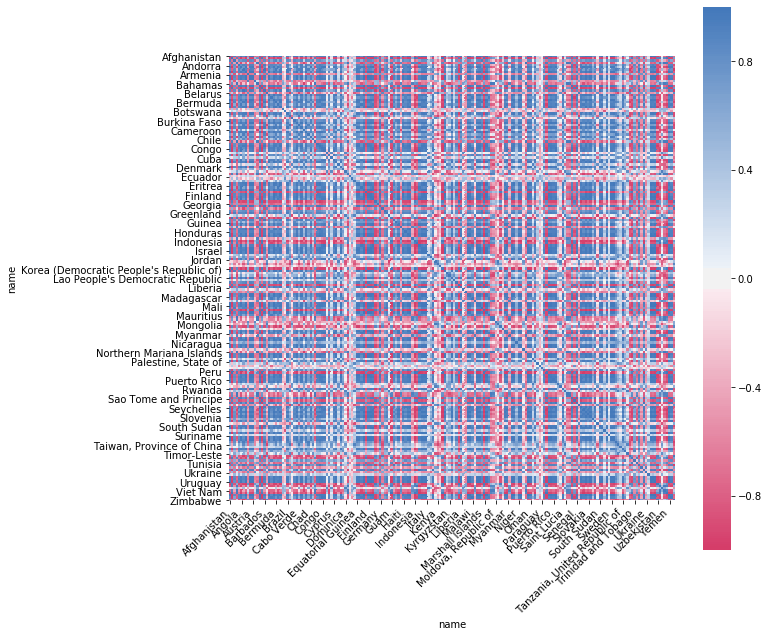

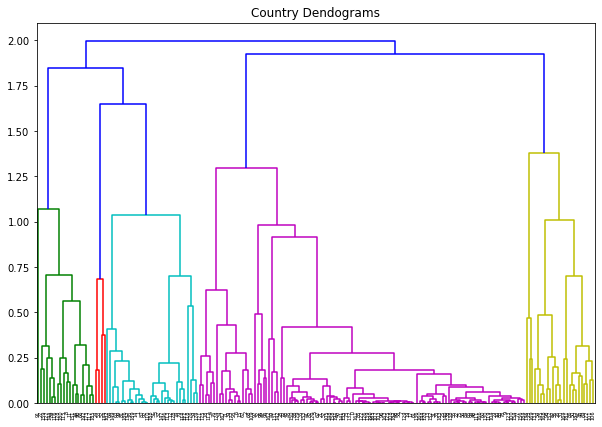

In [255]:
disease="Cardiovascular diseases"
measure="DALYs (Disability-Adjusted Life Years)"
plot_world_groups(rateData, disease, measure, cut_off_Range=np.arange(0, 2, 0.05), distance="correlation")

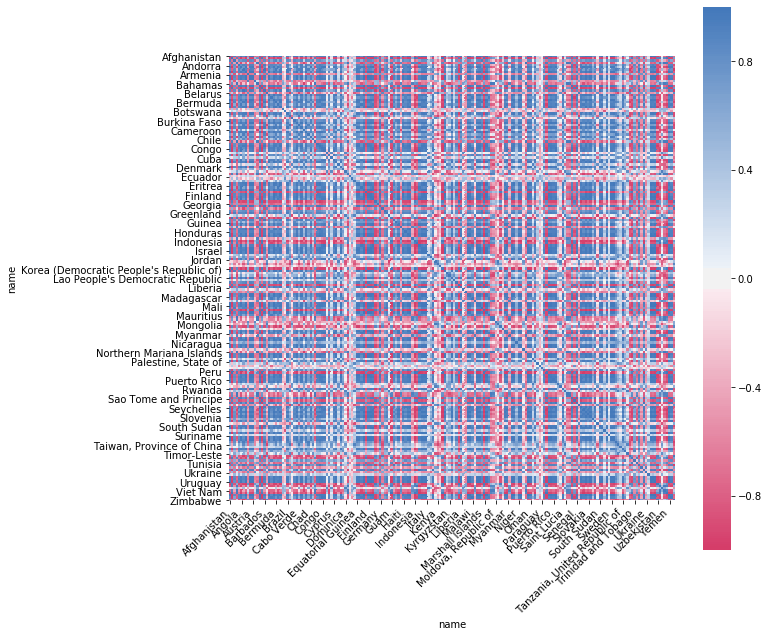

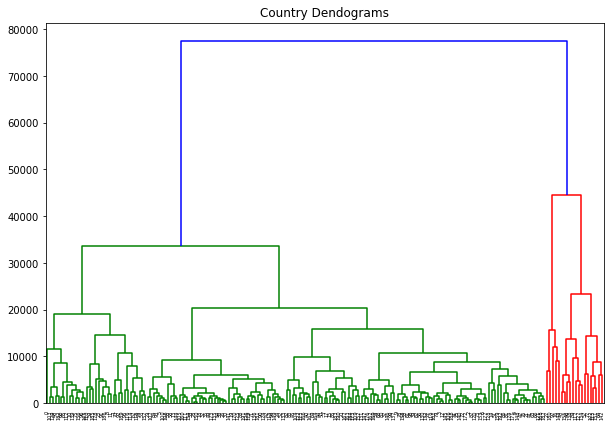

In [251]:
disease="Cardiovascular diseases"
measure="DALYs (Disability-Adjusted Life Years)"
plot_world_groups(rateData, disease, measure, cut_off_Range=np.arange(0, 20000, 1000), distance="euclidean")

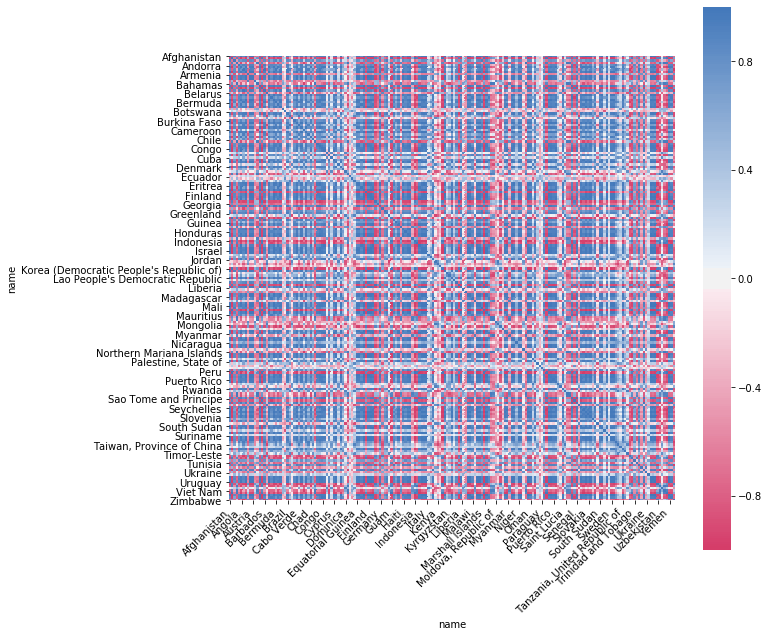

In [234]:
#Correlation matrix
corr=tuberculosisDeaths.corr(method ='pearson') 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 250, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

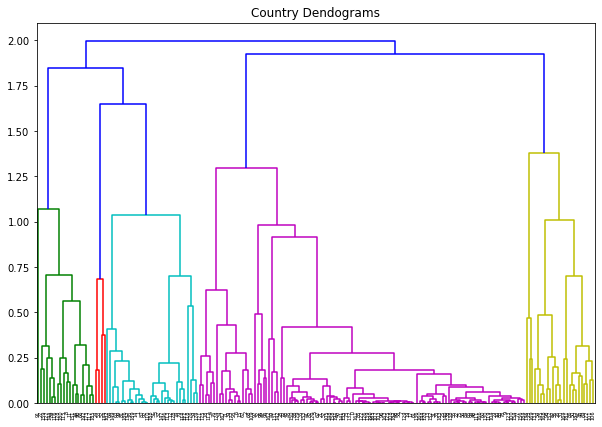

In [235]:
tuberculosisDeaths2=tuberculosisDeaths.transpose()
#print(tuberculosisDeaths2)
plt.figure(figsize=(10, 7))
plt.title("Country Dendograms")
link=shc.linkage(tuberculosisDeaths2, metric="correlation", method="single")
dend = shc.dendrogram(link)

In [236]:
dataToPlot=tuberculosisDeaths2.copy()
countries=tuberculosisDeaths2.index
dataToPlot["location"]=countries
dataToPlot=dataToPlot.reset_index()[["location"]].rename(columns={"location": "name"})
dataToPlot.index=dataToPlot.index.rename("Index")
dataToPlot=pd.merge(dataToPlot, countryInfo[["name", "alpha-3", "region", "sub-region"]], on="name", how="inner")
dataToPlot

name alpha-3    region                       sub-region
0              Afghanistan     AFG      Asia                    Southern Asia
1                  Albania     ALB    Europe                  Southern Europe
2                  Algeria     DZA    Africa                  Northern Africa
3           American Samoa     ASM   Oceania                        Polynesia
4                  Andorra     AND    Europe                  Southern Europe
..                     ...     ...       ...                              ...
188               Viet Nam     VNM      Asia               South-eastern Asia
189  Virgin Islands (U.S.)     VIR  Americas  Latin America and the Caribbean
190                  Yemen     YEM      Asia                     Western Asia
191                 Zambia     ZMB    Africa               Sub-Saharan Africa
192               Zimbabwe     ZWE    Africa               Sub-Saharan Africa

[193 rows x 4 columns]

In [237]:
step_size=0.05
heights=np.arange(0, 1.5, step_size)
for height in heights:
    cutTree = shc.cut_tree(link, height=height)
    heightVector=[height]*len(cutTree)
    if height==0:       
        groups=pd.DataFrame({"name": countries})
        groups["val"]=cutTree
        groups["cut_off"]=heightVector
    else:
        groupsNew=pd.DataFrame({"name": countries})
        groupsNew["val"]=cutTree
        groupsNew["cut_off"]=heightVector
        groups=pd.concat([groups, groupsNew])
groups

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45]


name  val  cut_off
0              Afghanistan    0     0.00
1                  Albania    1     0.00
2                  Algeria    2     0.00
3           American Samoa    3     0.00
4                  Andorra    4     0.00
..                     ...  ...      ...
188               Viet Nam    1     1.45
189  Virgin Islands (U.S.)    1     1.45
190                  Yemen    0     1.45
191                 Zambia    0     1.45
192               Zimbabwe    2     1.45

[5790 rows x 3 columns]

In [238]:
toPlot=pd.merge(dataToPlot, groups, on="name", how="inner")

In [239]:
import plotly.express as px

fig = px.choropleth(toPlot, locations="alpha-3", color="val", hover_name="name", animation_frame="cut_off")
fig.show()


In [180]:
gapminder

country continent  year  lifeExp       pop   gdpPercap iso_alpha  \
0     Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG   
1     Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG   
2     Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG   
3     Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG   
4     Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG   
...           ...       ...   ...      ...       ...         ...       ...   
1699     Zimbabwe    Africa  1987   62.351   9216418  706.157306       ZWE   
1700     Zimbabwe    Africa  1992   60.377  10704340  693.420786       ZWE   
1701     Zimbabwe    Africa  1997   46.809  11404948  792.449960       ZWE   
1702     Zimbabwe    Africa  2002   39.989  11926563  672.038623       ZWE   
1703     Zimbabwe    Africa  2007   43.487  12311143  469.709298       ZWE   

      iso_num  
0           4  
1           4  
2           4  
3           4  
4           4  
...       ...  
1699      716  
1700      716  
1701      716  
1702      716  
1703      716  

[1704 rows x 8 columns]

In [29]:
data2['cause'].unique().tolist()

['Neglected tropical diseases and malaria',
 'Mental disorders',
 'Musculoskeletal disorders',
 'Other infectious diseases',
 'Maternal and neonatal disorders',
 'Substance use disorders',
 'Diabetes and kidney diseases',
 'Neurological disorders',
 'Self-harm and interpersonal violence',
 'Nutritional deficiencies',
 'Digestive diseases',
 'Neoplasms',
 'Transport injuries',
 'Unintentional injuries',
 'Chronic respiratory diseases',
 'Other non-communicable diseases',
 'Skin and subcutaneous diseases',
 'Cardiovascular diseases',
 'HIV/AIDS and sexually transmitted infections',
 'Respiratory infections and tuberculosis',
 'Enteric infections',
 'Sense organ diseases']

We see that the disease categories in this dataset are not the same as in the previous one. The GBD query tool allows to extract values at for very specific diseases, or more aggregated categories of diseases. When performing future analyses, we have to decide which set of disease categories to choose.

Let us now look at the different measures included in the dataset.

In [30]:
data2['measure'].unique().tolist()

['YLLs (Years of Life Lost)',
 'Incidence',
 'Deaths',
 'Prevalence',
 'YLDs (Years Lived with Disability)',
 'DALYs (Disability-Adjusted Life Years)']

Let's look at the Years of Life Lost. To decide which metric (absolute number, percentage or rate) to take, we compare the values of these metrics for the same disease in two countries which are close to each other, but have a different population.

In [31]:
data2[(data2.measure == 'YLLs (Years of Life Lost)') & (data2.cause == 'Neoplasms') & ((data2.location == 'Luxembourg')|(data2.location == 'Netherlands')) & (data2.year == 2017)]

measure     location   sex       age      cause  \
362049  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
362050  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
362051  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
269237  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
269238  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
269239  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   

         metric  year            val          upper          lower  
362049   Number  2017   24719.846391   26942.056844   22658.815482  
362050  Percent  2017       0.362265       0.371621       0.350915  
362051     Rate  2017    4185.926360    4562.223573    3836.922427  
269237   Number  2017  938823.389505  993245.867184  886666.298582  
269238  Percent  2017       0.415261       0.421762       0.405521  
269239     Rate  2017    5513.054268    5832.639480    5206.772089

We will work with the rate of YLLs over the population (instead of the total number, or the percentage of all years of life lost for diseases), so we can compare the impact of different diseases in different countries.

Now, we can visualise this data on a map.

In [33]:
# Lets intereact with our data to explore it 
@interact
def interact_yll(year = list(np.append(data2.year.unique(),[0])),
                        disease = list(np.append(data2.cause.unique(), [0]))):
    yll_subset = data2
    yll_subset = data2[(data2['year']==year) & (data2['cause'] == disease) & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
    plot_map(yll_subset)
    
    return yll_subset

interactive(children=(Dropdown(description='year', options=(1993, 1992, 1991, 1990, 1994, 1995, 1996, 1997, 19…

Not all countries are correctly linked to their shape on the map in this visualisation: this still has to be fixed.

We can see very interesting clusters of countries pop up for different diseases, i.e. for neoplasms (cancers), neglected tropical diseases and malaria, substance abuse disorders, and more. This is clearly an interesting measure to look at.

What still has to be done:
* DONE Compare the different measures and choose which ones will be used for future analyses.
* Extend the analyses of all measures to look at the evolution over time (this was not yet done for the YLL).
* Decide on a set of disease categories to analyse. Thoroughly check this dataset to make sure any more needed cleaning and wrangling is done.
* Fix the visualisation so that all countries are correctly visualised. DONE Add a slider to more easily see the evolution over time.

Then, more substantive analyses can be made:
* Which diseases have the largest impact on the different countries? Look at a top 1,2,3...? This information can then be used to steer the analysis for the next research questions.

## 1.4 Comparison of measures

Let's look for the top 5 diseases with the biggest impact worldwide in 2017 according to the different measures.

In [61]:
# Create a dataframe to store the aggregated values for every measure for every disease
df_measures = pd.DataFrame()

for measure in data2.measure.unique():
    # Compute the total sum of this measure for all countries, per diseases
    subset = data2[(data2.measure == measure) & (data2.metric == 'Number') & (data2.year == 2017)]
    # Rank this descendingly
    top = subset.groupby('cause').sum().sort_values('val', ascending=False)[['val']]
    # Show the top 5
    df_measures[measure] = top['val']
    print("======")
    print(measure)
    print(top.head())

YLLs (Years of Life Lost)
                                                  val
cause                                                
Cardiovascular diseases                  3.286893e+08
Neoplasms                                2.245686e+08
Maternal and neonatal disorders          1.674996e+08
Respiratory infections and tuberculosis  1.480551e+08
Enteric infections                       8.457405e+07
Incidence
                                                  val
cause                                                
Respiratory infections and tuberculosis  1.984277e+10
Enteric infections                       7.091577e+09
Other non-communicable diseases          4.888111e+09
Skin and subcutaneous diseases           4.877190e+09
Nutritional deficiencies                 1.486709e+09
Deaths
                                                  val
cause                                                
Cardiovascular diseases                  1.770676e+07
Neoplasms                              

The different measures clearly give rise to very different and interesting rankings. From these rankings and the definition of the measures, we can infer the following:

* **Deaths** represent, of course, how many people actually die from these diseases. Since this is the most intuitive measure, let us compare the other measures with this.
* **YLLs (Years of Life Lost)** generates a rather similar ranking to the deaths one. However, this takes into account the age at which the person dies from this diseases: that explains why maternal and neonatal disorders is number three in this ranking, while it is not in the top 5 of deaths, because people die at a much earlier age from these disorders, leading to a higher number of years of life lost.
* **YLDs (Years Lived with Disability)** shows mostly diseases from which people don't (quickly) die, but which have a high impact on quality of life (disabilities which have a high impact are weighted higher in this measure), such as musculoskeletal disorders (such as paralysis).
* **DALYs (Disability-Adjusted Life Years)** is defined as the sum of the Years of Life Lost and Years Lived with Disability, leading to the 'number of healthy life years lost'. This can be seen in the ranking: it is a mix of diseases from which many people die, such as cardiovascular diseases and neoplasms (cancers), and diseases which have a long-lasting high impact on life (such as musculoskeletal diseases).
* **Incidence** is the number of people who contracted a certain disease in 2017. Here we see some diseases, like respiratory infections, skin and subcutaneous diseases and others, which are very common, but are quickly cured: so the people don't die from them and don't have to live with them for long, when comparing to the deaths ranking.
* **Prevalence** is the number of people who lived with that disease in 2017. This metric can be compared to the Years Lived with Disabilities, since they both emphasise diseases people live with for a long time, but this metric is not weighted by the impact of the disease on the quality of life, so diseases like Sense organ diseases (like hearing or vision impairment), which have a relatively lower impact than musculoskeletal diseases, are ranked higher.

All of these measures clearly have their own merit and provide different insights. However, since we want to explore the impact diseases have on society, the DALYs measure is probably the most interesting.

Let's look at the (Pearson) correlations between the measures to see if we can infer further information from this.

In [62]:
df_measures.corr(method='pearson')

YLLs (Years of Life Lost)  Incidence  \
YLLs (Years of Life Lost)                                1.000000   0.108623   
Incidence                                                0.108623   1.000000   
Deaths                                                   0.907980  -0.033706   
Prevalence                                              -0.239599   0.287789   
YLDs (Years Lived with Disability)                      -0.320851  -0.150350   
DALYs (Disability-Adjusted Life Years)                   0.861276   0.139428   

                                          Deaths  Prevalence  \
YLLs (Years of Life Lost)               0.907980   -0.239599   
Incidence                              -0.033706    0.287789   
Deaths                                  1.000000   -0.173422   
Prevalence                             -0.173422    1.000000   
YLDs (Years Lived with Disability)     -0.151999    0.292907   
DALYs (Disability-Adjusted Life Years)  0.806499   -0.090268   

                                        YLDs (Years Lived with Disability)  \
YLLs (Years of Life Lost)                                        -0.320851   
Incidence                                                        -0.150350   
Deaths                                                           -0.151999   
Prevalence                                                        0.292907   
YLDs (Years Lived with Disability)                                1.000000   
DALYs (Disability-Adjusted Life Years)                            0.179346   

                                        DALYs (Disability-Adjusted Life Years)  
YLLs (Years of Life Lost)                                             0.861276  
Incidence                                                             0.139428  
Deaths                                                                0.806499  
Prevalence                                                           -0.090268  
YLDs (Years Lived with Disability)                                    0.179346  
DALYs (Disability-Adjusted Life Years)                                1.000000

* **Deaths** and **YLLs** are strongly positively correlated. This shows that even though YLLs take into account how old a person is at time of death, this only slightly changes the ranking.
* **DALYS** are strongly positively correlated with YLLs (and as such also with Deaths), and only weakly positively correlated with YLDs. This means that apparently, the YLLs have a much higher impact on this value than the YLDs.
* Both **Prevalence** and **YLDs** are negatively correlated with Deaths. This affirms our conclusion from earlier that these measures emphasize diseases from which people don't always die, but just live with for a long time.
* Similarly, **Incidence** and **YLDs** are negatively correlated: showing that YLDs emphasise diseases that not many people get each year, but with which they do live for a long time.
* Also **Prevalence** and **Deaths** are negatively correlated, showing that diseases with high prevalence are diseases with which people live for a long time, but which don't always cause death.

# 2. How is the prevalence of different diseases linked to different risk factors?

## 2.1 Cardiovascular diseases

To better understand the risks factors for cardiovascular diseases, we analyse this dataset: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset, which contains data about the health condition of a list of people, including whether or not they have cardiovascular diseases.

### 2.1.1 Data cleaning/exploration

In [32]:
df=pd.read_csv("cardio_train.csv", delimiter=';')
print(df.shape)
df.head(5)

(70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [33]:
# No missing data (yey!)
df.isnull().values.any()

False

The feature "age" is given as a integer amount of days, let's convert this to a float in years.

In [34]:
# approximation: 1 year = 365 days
df['age'] = df['age'] / 365

**Let's check if each column has realistic values:**

In [35]:
# The range of ages seems reasonable
print(np.sort(df['age'].unique()))

[29.58356164 29.75068493 29.80273973 ... 64.90958904 64.93424658
 64.96712329]


In [36]:
# there seem to be some very short and tall people in this dataset !! (shortest person ever recorded was 54.6 cm)
print(np.sort(df['height'].unique()))

[ 55  57  59  60  64  65  66  67  68  70  71  72  74  75  76  80  81  91
  96  97  98  99 100 104 105 108 109 110 111 112 113 117 119 120 122 125
 128 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 200 207
 250]


[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0E3DB8408>]] 165    5853
160    5022
170    4679
168    4399
164    3396
       ... 
81        1
80        1
207       1
76        1
64        1
Name: height, Length: 109, dtype: int64


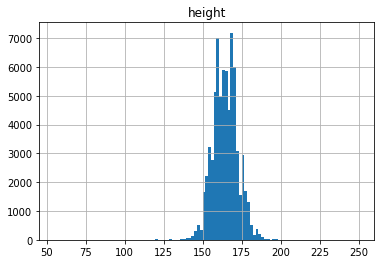

In [37]:
# There seem to be many different very short people in this dataset, let's visualize the distribution.
hist = df.hist(bins=len(df['height'].unique()), column="height")
print(hist, df['height'].value_counts())

In [38]:
# The distribution does seem to be sharply peaked around the realistic value. Let's remove the unrealistic outliers
realistic = df[df['height']>120]
realistic = realistic[realistic['height']<210]

In [39]:
# Let's split the dataset into male and female and determine the average height
print('genders: '+str(realistic['gender'].unique()))

females = realistic[realistic['gender'] == 1]
males = realistic[realistic['gender'] == 2]

print('Average height of a female: '+ str(np.round(females['height'].mean(),2))+' cm')
print('Average height of a male: '+ str(np.round(males['height'].mean(),2))+' cm')

genders: [2 1]
Average height of a female: 161.43 cm
Average height of a male: 170.04 cm


These values seem quiet low, however, we don't know when/where this data was recorded. <br>
We will get back to this and try to figure out where this data was recorded.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0E46CFC88>]],
      dtype=object)

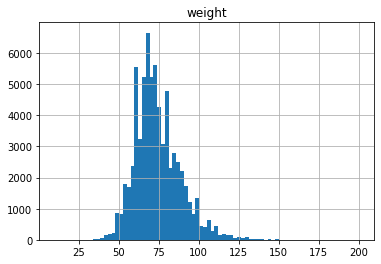

In [40]:
# There are also some unrealistic low weight values (expressed in kg)
hist = realistic.hist(bins=80, column="weight")
hist

In [41]:
print('low weights: '+str(np.sort(realistic['weight'].unique())[:10]))

low weights: [10. 11. 21. 22. 23. 28. 29. 30. 31. 32.]


In [42]:
#Remove extremely low weights
realistic = realistic[realistic['weight']>35]

In [43]:
# ap_hi: Systolic (arterial) blood pressure (pressure just outside the heart while it is ejecting)
# ap_hi: Diastolic (arterial) blood pressure (pressure just outside the heart while it is filling)
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ -150  -140  -120  -115  -100     1     7    10    11    12    13    14
    15    16    17    20    24    60    70    80    85    90    93    95
    96    97    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   132
   133   134   135   136   137   138   139   140   141   142   143   144
   145   146   147   148   149   150   151   152   153   154   155   156
   157   158   159   160   161   162   163   164   165   166   167   168
   169   170   171   172   173   174   175   176   177   178   179   180
   181   184   185   187   188   190   191   193   195   196   197   199
   200   202   207   210   215   220   230   240   309   401   701   806
   902   906   907   909   960  1110  1130  1202  1205  1300  1400  1409
  1420  1500  1620  2000 11020 11500 13010 14020 16020]
[  -70     0     1     6     7     8     9    10    15    20    30  

We can assume these negative pressures to be typos since their magnitude is realistic

In [44]:
#Fix the negative values
realistic = realistic.abs()

In [45]:
# In reality systolic blood pressure is rarely much lower lower than 90 or higher than 200
realistic = realistic[realistic['ap_hi']>59]
realistic = realistic[realistic['ap_hi']<241]
realistic = realistic[realistic['ap_lo']>39]
realistic = realistic[realistic['ap_lo']<200]
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ 60.  70.  80.  85.  90.  93.  95.  96.  97.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 184. 185. 187. 188. 190. 191. 193.
 195. 196. 197. 200. 202. 210. 215. 220. 230. 240.]
[ 40.  45.  49.  50.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 118. 119.
 120. 121. 122. 125. 126. 130. 135. 140. 150. 160. 170. 180. 182. 190.]


What is also an interesting and important parameter when trying to quantify the performance of the heart is "Pulse Pressure" (ap_pulse) which can simply be calculated as follows: ap_pulse = ap_hi - ap_lo.

In [46]:
# Let's add thise parameter into our dataframe
realistic['ap_pulse'] = realistic['ap_hi'] - realistic['ap_lo']
df1 = realistic.pop('cardio')
realistic['cardio'] = df1
realistic.head()

id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0  0.0  50.391781     2.0   168.0    62.0  110.0   80.0          1.0   1.0   
1  1.0  55.419178     1.0   156.0    85.0  140.0   90.0          3.0   1.0   
2  2.0  51.663014     1.0   165.0    64.0  130.0   70.0          3.0   1.0   
3  3.0  48.282192     2.0   169.0    82.0  150.0  100.0          1.0   1.0   
4  4.0  47.873973     1.0   156.0    56.0  100.0   60.0          1.0   1.0   

   smoke  alco  active  ap_pulse  cardio  
0    0.0   0.0     1.0      30.0     0.0  
1    0.0   0.0     1.0      50.0     1.0  
2    0.0   0.0     0.0      60.0     1.0  
3    0.0   0.0     1.0      50.0     1.0  
4    0.0   0.0     0.0      40.0     0.0

In [47]:
# We find that in some cases the the diastolic pressure is higher than the systolic pressure, this is physiologically impossible.
print(np.sort(realistic['ap_pulse'].unique()))

[-90. -85. -75. -70. -65. -60. -50. -45. -40. -35. -30. -25. -20. -10.
  -5.   0.   5.   9.  10.  11.  12.  14.  15.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 113. 114. 115. 120. 121. 130. 135. 140.]


In [48]:
# Remove negative values and unrealisticly high values.
realistic = realistic[realistic['ap_pulse']>0]
realistic = realistic[realistic['ap_pulse']<100]
print(np.sort(realistic['ap_pulse'].unique()))

[ 5.  9. 10. 11. 12. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.
 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82.
 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [49]:
# The other features seem to be clean
print(np.sort(realistic['cholesterol'].unique()))
print(np.sort(realistic['gluc'].unique()))
print(np.sort(realistic['smoke'].unique()))
print(np.sort(realistic['alco'].unique()))
print(np.sort(realistic['active'].unique()))
print('Data lost in the cleaning process: '+str(100*(70000-realistic.shape[0])/70000)+' %')

[1. 2. 3.]
[1. 2. 3.]
[0. 1.]
[0. 1.]
[0. 1.]
Data lost in the cleaning process: 2.33 %


**Now let's see how the different features are correlated.**

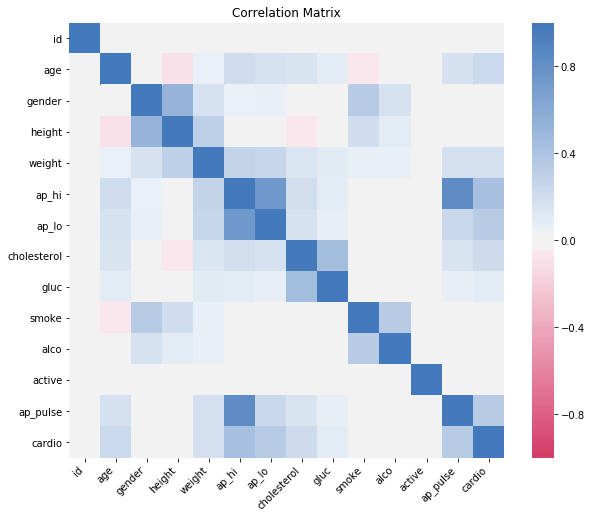

In [50]:
corr = realistic.corr()

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 250, n=200),
    square=True
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Implementing a measure of obesity: BMI**

Height & weight are also clearly strongly correlated, which makes a lot of sense. We would be more interested in the "obesity" of the patient, which is better quantified by the Body Mass Index: BMI = weight / height². Let us remove "height" and "weight" from out dataframe and instead combine them into BMI.

In [51]:
df = realistic

df['weight'] = df['weight'] / (df['height']/100)**2
df = df.rename(columns = {"weight": "BMI"})
df = df.drop(columns=['height'])
df.head()

id        age  gender        BMI  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  0.0  50.391781     2.0  21.967120  110.0   80.0          1.0   1.0    0.0   
1  1.0  55.419178     1.0  34.927679  140.0   90.0          3.0   1.0    0.0   
2  2.0  51.663014     1.0  23.507805  130.0   70.0          3.0   1.0    0.0   
3  3.0  48.282192     2.0  28.710479  150.0  100.0          1.0   1.0    0.0   
4  4.0  47.873973     1.0  23.011177  100.0   60.0          1.0   1.0    0.0   

   alco  active  ap_pulse  cardio  
0   0.0     1.0      30.0     0.0  
1   0.0     1.0      50.0     1.0  
2   0.0     0.0      60.0     1.0  
3   0.0     1.0      50.0     1.0  
4   0.0     0.0      40.0     0.0

The very last column of the data "cardio" is a binary value which determines wether the concidered person was diagnosed with cardio vascular disease. <br> Note that in reality this is not at all "binary", as it doesn't quanity the severity/type of cardio vascular disease.<br>

Let's try to get a **deeper understanding of the different features in this dataset before attemption to draw conclusions.**

### 2.1.2 Age

Why is cardiovascular disease the most common cause of death? <br>
From a medical point of view, cardiovascular disease is fairly well understood, so why is it that as of today it can't simply be prevented?

It turns out that cardiovascular disease comes with a certain level of "inevetability", this is in part due to a phenonmenon known as "arterial stiffening" which is directly related to ageing.

Large arteries are roughly devided into 3 main sections:
<img src="section-artery.jpg" width="400" height="180">

It is the middle section that causes the main problem, it contains elastic fibres (a protein known as elastin) which gives the artery its elastic properties and helps the blood to be pumped around in your body. As it turns out, since this layer is sandwhiched between two other layers, our body has trouble repairing/replacing the elastin as it degrades over time. Additionally it has been shown that elastin proteins have an approximate half-life of 74 years (Shapiro et al., 1991). This value is relatively close to the current life expectancy in developed countries (~80y). <br> (Another direct reason for ageing is telomere shorting which causes DNA damage and cell death).

Observe that, the feature "age" is strongly correlation to the prevalence of cardio vascular disease which is very much expected concidering what was discussed above.

### 2.1.3 Cholesterol

Cholesterol plays a crucial role in the cell membrane of every cell in your body, it also helps your body synthesize steroid hormones, bile acid and vitamin D. So how is it possible that its prevalence is so strongly correlated to the most common cause of death?

Cholesterol is a lipid, it is a type of "fat". It can build up excessively in the blood circulation and can be hard for the body to remove. The cholesterol (plaque) attaches to the blood vessel walls caussing them to narrow. This negatively effects the heamodynamics and can ultimately result in total occlusion of a blood vessle. The blockage results in poor perfusion and thus insufficient oxygen being delivered to the tissue.<br>

<img src="plaque.png" width="300" height="130">

This process is accelerated by a unhealthy diet and is thus correlated to obesity.

### 2.1.4 Blood Pressure

elevated blood pressure is in general a result of many influencing factors.

* Short term: When you drink a large amount of fluid or eat something (salty), your blood pressure will rise. In young, healthy individuals the body is easily counteracts this by its many negative feedback loops.

* Long term: Blood pressure increases with age as a result of arterial stiffening, build up of cholesterol, ... <br>

Note that cardiovascular disease, especially coronary heart disease is a **positive feedbackloop**! This is exactly what makes it so deadly. <br>
explanation: If the heart lowers in function, it is unable to pump blood around the body properly and provide the different tissues of sufficient oxygen. This means all tissues in the body will lower in function, including the heart muscles themselves. This causes the heart function to decrease even further. This escalates in a condition known as heart failure.

### 2.1.5 Other interesting correlations

Interestingly, the strongest correlations in this dataset are not related to cardiovascular disease:

- height ~ gender
- height ~ weight
- cholesterol ~ glocuse levels (unhealthy diet)
- smoking ~ alcohol (unhealthy lifestyles)
- smoking ~ gender

**side quest:** Especially the last correlation is interesting. Which gender smokes most? How big is this difference?

In [52]:
GS = df[['gender','smoke']]

females = GS[GS['gender']==1]
males = GS[GS['gender']==2]

print('male smokers: '+str(np.round(100*sum(males['smoke'])/males.size, 3))+'%')
print('female smokers: '+str(np.round(100*sum(females['smoke'])/females.size, 3))+'%')

male smokers: 10.95%
female smokers: 0.89%


According to this dataset, men smoke 10x more than woman!<br>
This approximately agrees with findings in literature.

### 2.1.6 Feature importance

Correlations alone aren't always an accurate way of describing which features are truly important. Forest algorithm to determine which features are important:

In [53]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

Feature ranking:
1. feature 0 (0.356879)age
2. feature 2 (0.313090)BMI
3. feature 3 (0.114377)ap_hi
4. feature 10 (0.071101)ap_pulse
5. feature 4 (0.061604)ap_lo
6. feature 5 (0.041434)cholesterol
7. feature 6 (0.013479)gluc
8. feature 1 (0.009778)gender
9. feature 9 (0.007135)active
10. feature 7 (0.005720)smoke
11. feature 8 (0.005403)alco


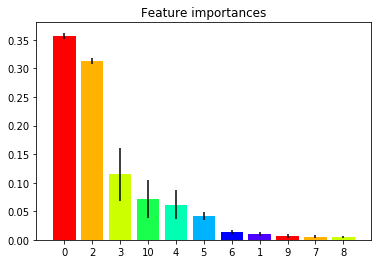

In [54]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color=[(1, 0, 0, 1),(1, 0.7, 0, 1),(0.8, 1, 0, 1),(0.1, 1, 0.3, 1),(0, 1, 0.7, 1),(0, 0.7, 1, 1),(0, 0, 1, 1),(0.3, 0, 1, 1)], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

We find similar results as to the correlations, however, here the blood pressure seems to play much more important role. 
BMI also turns out to be a very important factor!

### 2.1.7 Conclusion

Many of the above factors can not directly be influenced/solved: 
* We can't prevent ourselves from ageing 
* High blood pressure is a result of other factors: ageing (arterial stiffening), cholesterol levels, salt/fluid intake, ...

So in order to **minimize our risk of cardiovascular disease** we should try to keep our BMI and cholesterol levels as low as possible. <br>
This can both be done be following a **healthy diet and working out (burning fat).**

## 2.2 Further risk factor analysis

We can now do the following things:
* Use the data from question 1 to analyse specific risk factors and the phenomena observed in that question.
* Perform analyses like this one for cardiovascular diseases for other diseases.
* Try to link the risk factors identified here with health data about different countries.

## 2.3 Risk factors in GBD dataset

In [35]:
df_risk_exposure = pd.read_csv("data/risk-exposure.csv")
df_risk_exposure

measure location   sex       age  \
0      Summary exposure value    Chile  Both  All Ages   
1      Summary exposure value    Chile  Both  All Ages   
2      Summary exposure value  Uruguay  Both  All Ages   
3      Summary exposure value  Uruguay  Both  All Ages   
4      Summary exposure value  Uruguay  Both  All Ages   
...                       ...      ...   ...       ...   
54595  Summary exposure value  Iceland  Both  All Ages   
54596  Summary exposure value  Iceland  Both  All Ages   
54597  Summary exposure value  Iceland  Both  All Ages   
54598  Summary exposure value  Iceland  Both  All Ages   
54599  Summary exposure value  Iceland  Both  All Ages   

                                rei metric  year        val      upper  \
0          Impaired kidney function   Rate  1998   2.206156   6.254720   
1              High LDL cholesterol   Rate  1998  11.781258  13.439133   
2                       Alcohol use   Rate  1998  17.024161  23.759901   
3                          Drug use   Rate  1998   0.522109   0.767074   
4       High fasting plasma glucose   Rate  1998   4.868456   7.082223   
...                             ...    ...   ...        ...        ...   
54595                      Drug use   Rate  2010   0.357157   0.453165   
54596   High fasting plasma glucose   Rate  2010   4.233970   6.021667   
54597  High systolic blood pressure   Rate  2010   8.919840   9.762758   
54598          High body-mass index   Rate  2010  16.592588  21.117256   
54599      Low bone mineral density   Rate  2010   6.048110   7.164240   

           lower  
0       0.991032  
1      10.229339  
2      11.266339  
3       0.386055  
4       3.521469  
...          ...  
54595   0.292774  
54596   3.041318  
54597   8.028875  
54598  12.963985  
54599   5.026554  

[54600 rows x 10 columns]

Which risk factors are in the GBD dataset?

In [41]:
print(df_risk_exposure['rei'].unique())

['Impaired kidney function' 'High LDL cholesterol' 'Alcohol use'
 'Drug use' 'High fasting plasma glucose' 'High systolic blood pressure'
 'High body-mass index' 'Low bone mineral density' 'Low physical activity'
 'Intimate partner violence']


In [45]:
df_risk_exposure['year'].unique()

array([1998, 2001, 2016, 2000, 2009, 1996, 1991, 2008, 2005, 1999, 1995,
       2010, 2013, 1994, 2012, 2014, 2006, 2007, 1990, 2017, 1997, 1993,
       2011, 2002, 2015, 2003, 1992, 2004], dtype=int64)

# 3. How is this linked to the living conditions within each country?

## 3.1 Economics

Gather economical data and merge them to the dataset and continue exploration with this dataset (to find links)

In [55]:
economic = pd.read_csv("data/gdp_capita.csv")
economic

Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP per capita (current US$)  NY.GDP.PCAP.CD   
1     Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2          Angola          AGO  GDP per capita (current US$)  NY.GDP.PCAP.CD   
3         Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4         Andorra          AND  GDP per capita (current US$)  NY.GDP.PCAP.CD   
..            ...          ...                           ...             ...   
259        Kosovo          XKX  GDP per capita (current US$)  NY.GDP.PCAP.CD   
260   Yemen, Rep.          YEM  GDP per capita (current US$)  NY.GDP.PCAP.CD   
261  South Africa          ZAF  GDP per capita (current US$)  NY.GDP.PCAP.CD   
262        Zambia          ZMB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
263      Zimbabwe          ZWE  GDP per capita (current US$)  NY.GDP.PCAP.CD   

           1960        1961        1962        1963        1964        1965  \
0           NaN         NaN         NaN         NaN         NaN         NaN   
1     59.773194   59.860874   58.458015   78.706388   82.095231  101.108305   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
259         NaN         NaN         NaN         NaN         NaN         NaN   
260         NaN         NaN         NaN         NaN         NaN         NaN   
261  443.009816  454.962013  473.011615  511.497253  548.995942  584.704072   
262  232.188867  220.042137  212.578123  213.896441  242.384333  303.281910   
263  278.813699  280.828951  276.688781  277.479715  281.558440  293.308854   

     ...          2011          2012          2013          2014  \
0    ...  24985.993281  24713.698045  25025.099563  25533.569780   
1    ...    591.162346    641.872034    637.165044    613.856333   
2    ...   4615.468028   5100.095808   5254.882338   5408.410496   
3    ...   4437.177794   4247.614342   4413.082887   4578.667934   
4    ...  41100.729938  38392.943901  40626.751632  42300.334128   
..   ...           ...           ...           ...           ...   
259  ...   3736.363217   3600.673475   3876.958302   4054.721339   
260  ...   1374.621313   1446.536280   1607.152275   1674.002766   
261  ...   8007.377412   7501.407280   6829.020465   6428.293579   
262  ...   1672.949830   1763.094184   1878.903489   1763.056239   
263  ...   1093.654002   1304.969802   1430.000818   1434.899340   

             2015          2016          2017          2018  2019  Unnamed: 64  
0    25796.380251  25239.600411  25630.266492           NaN   NaN          NaN  
1      578.466353    547.228110    556.302139    520.896603   NaN          NaN  
2     4166.979684   3506.072885   4095.812942   3432.385736   NaN          NaN  
3     3952.830781   4124.108543   4532.889198   5253.630064   NaN          NaN  
4    36039.653496  37224.108916  39134.393371  42029.762737   NaN          NaN  
..            ...           ...           ...           ...   ...          ...  
259   3574.543333   3697.121677   3948.088150   4281.292329   NaN          NaN  
260   1608.744312   1139.870568    963.494721    944.408499   NaN          NaN  
261   5730.934174   5272.627749   6127.462297   6374.015446   NaN          NaN  
262   1332.194321   1280.578447   1534.865371   1539.900158   NaN          NaN  
263   1445.071062   1464.583529   1602.403507   2146.996385   NaN          NaN  

[264 rows x 65 columns]

In [56]:
#exploded = economic.explode([economic.columns.to_list()[4: -1]])
exploded = economic.melt(id_vars=economic.columns.to_list()[0: 4], 
        var_name="Year", 
        value_name="GDP").drop(["Indicator Name","Indicator Code" ], 1)

In [57]:
exploded['Year'] = pd.to_numeric(exploded['Year'],errors='coerce')
exploded


Country Name Country Code    Year        GDP
0             Aruba          ABW  1960.0        NaN
1       Afghanistan          AFG  1960.0  59.773194
2            Angola          AGO  1960.0        NaN
3           Albania          ALB  1960.0        NaN
4           Andorra          AND  1960.0        NaN
...             ...          ...     ...        ...
16099        Kosovo          XKX     NaN        NaN
16100   Yemen, Rep.          YEM     NaN        NaN
16101  South Africa          ZAF     NaN        NaN
16102        Zambia          ZMB     NaN        NaN
16103      Zimbabwe          ZWE     NaN        NaN

[16104 rows x 4 columns]

To merge it with our dataframe we need to explode the years

In [58]:
merged = pd.merge(normalized, exploded, how = "inner", left_on = ["Code", "Year"], right_on=["Country Code","Year"])


In [59]:
merged

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
5440     Zimbabwe  ZWE  2013  0.009296                 0.099218   
5441     Zimbabwe  ZWE  2014  0.010014                 0.105632   
5442     Zimbabwe  ZWE  2015  0.010744                 0.110023   
5443     Zimbabwe  ZWE  2016  0.011585                 0.114236   
5444     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
5440        0.011727             0.021369       0.006827   
5441        0.012613             0.022560       0.007204   
5442        0.013356             0.023452       0.007553   
5443        0.014016             0.024233       0.007862   
5444        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
5440                               0.044394           0.021123  ...   
5441                               0.048202           0.022462  ...   
5442                               0.051376           0.023479  ...   
5443                               0.054342           0.024466  ...   
5444                               0.000000           0.000000  ...   

      Meningitis (deaths)  Lower respiratory infections (deaths)  \
0                0.050698                               0.178949   
1                0.046676                               0.164180   
2                0.045938                               0.160067   
3                0.051103                               0.178798   
4                0.051439                               0.178059   
...                   ...                                    ...   
5440             0.011463                               0.082555   
5441             0.011676                               0.084711   
5442             0.011913                               0.087093   
5443             0.012077                               0.088587   
5444             0.097736                               0.720904   

      Intestinal infectious diseases (deaths)  \
0                                    0.002315   
1                                    0.002235   
2                                    0.002192   
3                                    0.002115   
4                                    0.001900   
...                                       ...   
5440                                 0.000158   
5441                                 0.000169   
5442                                 0.000175   
5443                                 0.000183   
5444                                 0.000000   

      Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                                 0.012598           0.011817   
1                                 0.011458           0.025724   
2                              

In [60]:
@interact
def scatter_plot(x=list(merged.select_dtypes('number').columns), 
                 y=list(merged.select_dtypes('number').columns)[1:],
                 year = list(np.append(merged.Year.unique(),[0])),
                 country = list(np.append(merged.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = merged
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

This does not seem to provide very clear conclusions yet. What can still be done:
* Perform statistical analyses on this data (e.g. look for a correlation).
* Look for other data on the living conditions of a country (e.g. HDI, Gini inequality index, government health budget)
* Try to cluster countries which exhibit similar characteristics.